In [69]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from typing import Union
tf.__version__

'1.15.0'

In [70]:
from tensorflow.examples.tutorials.mnist import input_data

In [71]:
# Function that draw a weight ditribution plot
def plot_histogram(weights_list: list,
                   image_name: str,
                   include_zeros=True):

    """A function to plot weights distribution"""

    weights = []
    for w in weights_list:
        weights.extend(list(w.ravel()))

    if not include_zeros:
        weights = [w for w in weights if w != 0]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    ax.hist(weights,
            bins=300,
            facecolor='green',
            edgecolor='green',
            alpha=0.7,
            range=(-0.3, 0.3))

    ax.set_title('Weight distribution')
    ax.set_xlabel('Values of weights')
    ax.set_ylabel('Number of weights')
    
    plt.show()
#     fig.savefig(image_name + '.png')

def number_of_parameters(var_list):
    return sum(np.prod(v.get_shape().as_list()) for v in var_list)

def mask_for_big_values(weights, pruning_threshold):

    small_weights = np.abs(weights) < pruning_threshold
    return np.logical_not(small_weights)

In [72]:
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Number of parameters: 227670.

Test set accuracy before training:  0.101
Epoch 1
Test set accuracy:  0.9454
Epoch 2
Test set accuracy:  0.9548
Epoch 3
Test set accuracy:  0.9656
Epoch 4
Test set accuracy:  0.9693
Epoch 5
Test set accuracy:  0.9722
Epoch 6
Test set accuracy:  0.9748
Epoch 7
Test set accuracy:  0.9748
Epoch 8
Test set accuracy:  0.9766
------------------------------After training without pruning--------------------------------


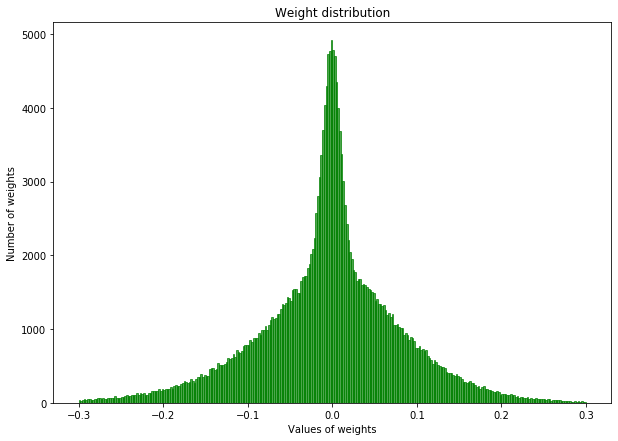

------------------------------After pruning--------------------------------


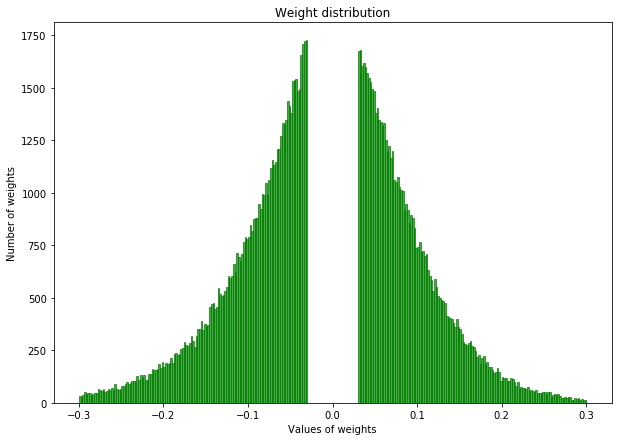

The pruned model saved successfully.


In [73]:
tf.reset_default_graph()
batch_size = 60

n_batch = mnist.train.num_examples//batch_size

#Two placeholder
x = tf.placeholder(tf.float32,[None,784])
y = tf.placeholder(tf.float32,[None,10])

# A simple feed-forward network
with tf.variable_scope('myvar',reuse=tf.AUTO_REUSE):

    W1 = tf.get_variable(name='W1',initializer=tf.random_normal([784,256])/100)
    W2 = tf.get_variable(name='W2',initializer=tf.random_normal([256,100])/100)
    W3 = tf.get_variable(name='W3',initializer=tf.random_normal([100,10])/100)

    
    b1 = tf.get_variable(name= 'b1',initializer=tf.random_normal([256])/100)
    b2 = tf.get_variable(name= 'b2',initializer=tf.random_normal([100])/100)
    b3 = tf.get_variable(name= 'b3',initializer=tf.random_normal([10])/100)



L12 = tf.nn.relu(tf.matmul(x,W1) + b1)
L23 = tf.nn.relu(tf.matmul(L12,W2) + b2)
prediction = tf.nn.softmax(tf.matmul(L23,W3) + b3)

#loss
loss = tf.reduce_mean(tf.square(y-prediction))
## Gradient decent
# train_step = tf.train.GradientDescentOptimizer(learning_rate=0.2).minimize(loss)
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
saver = tf.train.Saver()

print('Number of parameters: {}.\n'.format(int(number_of_parameters(tf.trainable_variables()))))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
# #     Weights before training
#     print('Weighs before training')
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))
    
    acc = sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels})
    print('Test set accuracy before training: ',str(acc))
    
    for epoch in range(8):
        for batch in range(n_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            sess.run(train_step,feed_dict={x:batch_xs,y:batch_ys})
            
        print('Epoch', epoch+1)
        test_acc = sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels})
        print('Test set accuracy: ',str(test_acc))
        
    saver.save(sess, "./Model/trained_model.ckpt")
    weights = []
    
    weights.append(sess.run(W1))
    weights.append(sess.run(W2))
    weights.append(sess.run(W3))
    weights.append(sess.run(b1))
    weights.append(sess.run(b2))
    weights.append(sess.run(b3))
    
    #Weight distribution after training and before pruning
    print('------------------------------After training without pruning--------------------------------')
    plot_histogram(weights,'weight_distribution_beftore_pruning',include_zeros=False)
    
    ##mask
    for weight_matrix,i in zip(weights,tf.trainable_variables()):
#         print(sess.run(i))
        mask = mask_for_big_values(weight_matrix,0.03)
#         print(mask.shape)
        sess.run(i.assign(weight_matrix * mask))
        
    
    #Check values of weights
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))

    weights_pruned = []
    
    weights_pruned.append(sess.run(W1))
    weights_pruned.append(sess.run(W2))
    weights_pruned.append(sess.run(W3))
    weights_pruned.append(sess.run(b1))
    weights_pruned.append(sess.run(b2))
    weights_pruned.append(sess.run(b3))
    
    
    #Weights distribution after pruning
    print('------------------------------After pruning--------------------------------')
    plot_histogram(weights_pruned,'weights_distribution_after_pruning',include_zeros=False)


    saver.save(sess, "./Model/pruned_model_without_fine_tuning.ckpt")
    print("The pruned model saved successfully.")
    #Check values of weights
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))

In [74]:
#Load the pruned model and inference without fine-tuning.
with tf.Session() as sess:
    saver.restore(sess, "./Model/pruned_model_without_fine_tuning.ckpt")

    L12p1 = tf.nn.relu(tf.matmul(x,W1) + b1)
    L23p1 = tf.nn.relu(tf.matmul(L12p1,W2) + b2)
    prediction1 = tf.nn.softmax(tf.matmul(L23p1,W3) + b3)

    correct_prediction1 = tf.equal(tf.argmax(y,1),tf.argmax(prediction1,1))
    
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1,tf.float32))
    test_accc = sess.run(accuracy1,feed_dict={x:mnist.test.images,y:mnist.test.labels})
    print('Test set accuracy after pruning without fine-tuning: ',str(test_accc))

INFO:tensorflow:Restoring parameters from ./Model/pruned_model_without_fine_tuning.ckpt
Test set accuracy after pruning without fine-tuning:  0.9773


In [75]:
#Functions for learning 
def _apply_prune_on_grads(grads_and_vars: list,threshold: float):

        # we need to make gradients correspondent
        # to the pruned weights to be zero

    grads_and_vars_sparse = []

    for grad, var in grads_and_vars:
        if 'weights' in var.name:
            small_weights = tf.greater(threshold, tf.abs(var))
            mask = tf.cast(tf.logical_not(small_weights), tf.float32)
            grad = grad * mask

        grads_and_vars_sparse.append((grad, var))
               
    return grads_and_vars_sparse

def _create_optimizer_sparse(loss: tf.Tensor,
                                 threshold: float,
                                 learning_rate: Union[tf.Tensor, float],
                                 momentum: Union[tf.Tensor, float]) -> tf.Operation:

    with tf.variable_scope('optimizer'):

        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                                   momentum=momentum,
                                                   name='optimizer')
        self.global_step = tf.Variable(0)
        grads_and_vars = optimizer.compute_gradients(loss)
        grads_and_vars_sparse = self._apply_prune_on_grads(grads_and_vars,
                                                               threshold)
        train_op = optimizer.apply_gradients(grads_and_vars_sparse,
                                                 global_step=self.global_step,
                                                 name='train_op')

        return train_op

INFO:tensorflow:Restoring parameters from ./Model/pruned_model_without_fine_tuning.ckpt
Epoch 1
Test set accuracy:  0.9802
Epoch 2
Test set accuracy:  0.9806
Epoch 3
Test set accuracy:  0.9809
Epoch 4
Test set accuracy:  0.981
Epoch 5
Test set accuracy:  0.9811


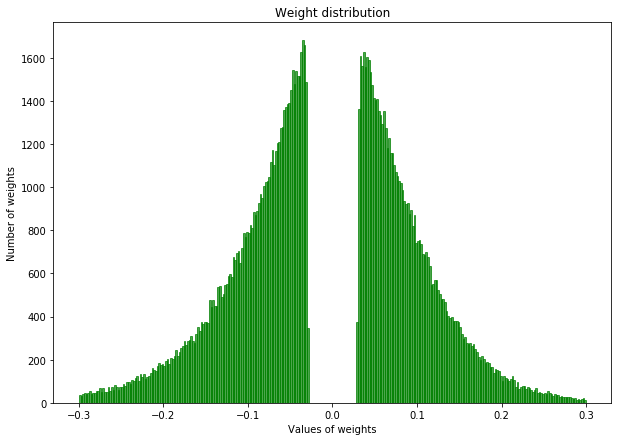

The fine-tuned pruned model saved successfully.


In [76]:
x = tf.placeholder(tf.float32,[None,784])
y = tf.placeholder(tf.float32,[None,10])    
with tf.variable_scope('op',reuse=tf.AUTO_REUSE):
    global_step = tf.get_variable(name='g',shape=[1],dtype=tf.float32,initializer=tf.constant_initializer(0.3))

with tf.Session() as sess1:

    saver.restore(sess1, "./Model/pruned_model_without_fine_tuning.ckpt")
    #sess1.run(tf.global_variables_initializer())
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))
    
    
    L12 = tf.nn.relu(tf.matmul(x,W1) + b1)
    L23 = tf.nn.relu(tf.matmul(L12,W2) + b2)
    prediction = tf.nn.softmax(tf.matmul(L23,W3) + b3)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)
    loss = tf.reduce_mean(tf.square(y-prediction))
    
    grads_and_vars = optimizer.compute_gradients(loss)
#     print(grads_and_vars)
    
    # to the pruned weights to be zero

    grads_and_vars_sparse = []

    for grad, var in grads_and_vars:
        if 'myvar' in var.name:
            small_weights = tf.greater(0.03, tf.abs(var))
            mask = tf.cast(tf.logical_not(small_weights), tf.float32)
            grad = grad * mask

        grads_and_vars_sparse.append((grad, var))
#     print(grads_and_vars_sparse)
        
    train_op = optimizer.apply_gradients(grads_and_vars_sparse)
#     print(train_op)
    batch_xs,batch_ys = mnist.train.next_batch(batch_size)
    correct_prediction1 = tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
    
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1,tf.float32))
    
    for epoch in range(5):
        for batch in range(n_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            sess1.run(train_op,feed_dict={x:batch_xs,y:batch_ys})
        
        print('Epoch', epoch+1)
        accc = sess1.run(accuracy1,feed_dict={x:mnist.test.images,y:mnist.test.labels})
        print('Test set accuracy: ',str(accc))
        
    #Fine-tuning pruned model
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))
    
    weightspf = []
    
    weightspf.append(sess1.run(W1))
    weightspf.append(sess1.run(W2))
    weightspf.append(sess1.run(W3))
    weightspf.append(sess1.run(b1))
    weightspf.append(sess1.run(b2))
    weightspf.append(sess1.run(b3))    
    ## Weight distribution of the fine-tuned pruned model
    plot_histogram(weightspf,'Weight_distribution_after_pruning_and_fine-tuning',include_zeros=False)
    saver.save(sess1, "./Model/fine_tuned_pruned_model.ckpt")
    print("The fine-tuned pruned model saved successfully.")